In [1]:
%config IPCompleter.greedy=True

In [2]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://www.minsal.cl/nuevo-coronavirus-2019-ncov/casos-confirmados-en-chile-covid-19/'
response = get(url)

In [4]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
#Almaceno los links de los archivos PDF
links = []
for table in html_soup.find_all('table'):
    for a in table.find_all('a'):
        links.append(a['href'])
    break

links

['https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-16-Casos-Confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-15-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-14-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-13-Casos-Confirmados-Covid-19.pdf']

In [6]:
import tabula

#Se extrae el pdf desde los links
df1 = tabula.read_pdf(links[0], pages=1)    

Got stderr: mar 16, 2020 7:52:56 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font Arial are not implemented in PDFBox and will be ignored



In [7]:
df = df1[0]
len(df.index)

163

In [8]:
#Seteo columnas del DataFrame, se elimina la primera y última fila, por último se elimina la columna 'Casos confirmados'
df.columns = df.iloc[0].values
df = df.drop([0,len(df.index)-1]).reset_index(drop=True)
df = df.drop(['Casos confirmados'], axis=1)
df=df.rename(columns = {'Centro de salud':'Centro_salud'})
df.columns

Index(['Región', 'Sexo', 'Edad', 'Centro_salud'], dtype='object')

In [9]:
#Se normaliza la columna sexo y Centro_salud, por último se reemplazan por valores que lo preceden
df['Sexo'] = df['Sexo'].str.replace('Fememino','Femenino')
df['Centro_salud'] = df['Centro_salud'].str.replace('\r',' ')
df = df.fillna(method='ffill')

In [10]:
#Se eliminan filas que no tengan sexo
df = df[df["Sexo"]!='—'].reset_index(drop=True)

In [11]:
#Se transforma el formato de la columna Edad, de String a Entero
#df['Edad'] = df['Edad'].astype(str).astype(int)

In [12]:
#Tabla final con todos los datos de contagios
df

,Región,Sexo,Edad,Centro_salud
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama
2,Atacama,Masculino,50,Hospital de Copiapó
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar
4,Metropolitana,Femenino,54,Clínica Alemana
...,...,...,...,...
151,Biobío,Femenino,47,Clinica Biobío
152,Araucanía,Masculino,35,Hospital Hernán Henríquez Aravena
153,Los Ríos,Femenino,1,Clinica Alemana Valdivia
154,Los Lagos,Femenino,20,Hospital de Puerto Montt


In [13]:
from datetime import datetime

#Exportamos los datos del día a CSV
df.to_csv(str(datetime.today().strftime('%d-%m-%Y')) + '.csv')

In [14]:
df1 = df.groupby('Región')['Región'].count().reset_index(name='Cantidad')

In [15]:
df1

,Región,Cantidad
0,Antofagasta,2
1,Araucanía,1
2,Atacama,1
3,Aysén,1
4,Biobío,4
5,Los Lagos,1
6,Los Ríos,1
7,Maule,9
8,Metropolitana,123
9,Valparaíso,1


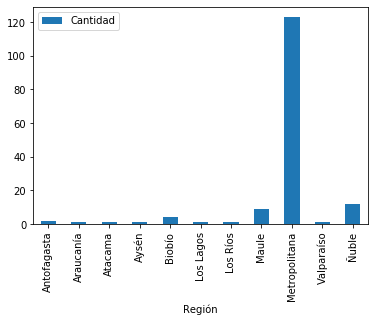

In [16]:
df1.plot(kind='bar',x='Región',y='Cantidad')

In [17]:
#df.hist(bins=6)

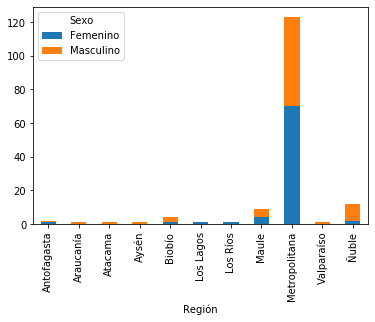

In [18]:
df.groupby(['Región','Sexo']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [19]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="Covid19-CL")
location = geolocator.geocode("Clínica Las Condes, Región Metropolitana, Chile")
print(location.address)
#Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
print((location.latitude, location.longitude))
#(40.7410861, -73.9896297241625)
#print(location.raw)
#{'place_id': '9167009604', 'type': 'attraction', ...}

Clinica Las Condes, 450, Estoril, Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, 7550000, Chile
(-33.3840374, -70.5309885140944)


In [20]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
df2 = df1.drop(['Cantidad'], axis=1)
lat = []
lon = []
for index, row in df2.iterrows():
    location = geocode('Región ' + row['Región'] + ', Chile')
    lat.append(location.latitude)
    lon.append(location.longitude)
df2['lat'] = lat
df2['lon'] = lon


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Región Los Lagos, Chile',), **{}).
Traceback (most recent call last):
  File "C:\Users\DiegoEliezer\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 1320, in do_open
    r = h.getresponse()
  File "C:\Users\DiegoEliezer\Anaconda3\lib\http\client.py", line 1321, in getresponse
    response.b

In [21]:
dfm = pd.merge(df, df2, on='Región')
dfm

,Región,Sexo,Edad,Centro_salud,lat,lon
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama,-22.455864,-68.927458
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama,-22.455864,-68.927458
2,Atacama,Masculino,50,Hospital de Copiapó,-26.385295,-70.047757
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar,-32.786024,-71.203457
4,Metropolitana,Femenino,54,Clínica Alemana,-33.435442,-70.676616
...,...,...,...,...,...,...
151,Biobío,Femenino,47,Clinica Biobío,-36.964842,-72.928386
152,Araucanía,Masculino,35,Hospital Hernán Henríquez Aravena,-38.671012,-72.256458
153,Los Ríos,Femenino,1,Clinica Alemana Valdivia,-39.819592,-73.243910
154,Los Lagos,Femenino,20,Hospital de Puerto Montt,-42.898024,-72.438891


In [22]:
import folium
from folium.plugins import MarkerCluster

map1 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='cartodbdark_matter',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in dfm.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + row.Edad + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90), icon=folium.Icon(color='red')))
mc.add_to(map1)
map1
#folium.CircleMarker(location= [location.latitude, location.longitude]).add_to(map1)
#df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#df_loc.apply(lambda row:folium.Marker(location=[row['lat'], row['lon']], popup = row['Edad']).add_to(map1), axis=1)
#map1

In [23]:
#El mapa se exporta a HTML
map1.save('home.html')